# Test run-length encoding and decoding functions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# System paths
root_dir = "/media/davidtvs/Storage/Datasets/airbus-ship-detection"
trainset_dir = os.path.join(root_dir, "train_v2")
testset_dir = os.path.join(root_dir, "test_v2")
train_rle = os.path.join(root_dir, "train_ship_segmentations_v2.csv")

## Run-length encode and decode functions

In [2]:
def rle_encode(mask):
    """Encodes a mask in run-length format.

    Source: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

    Arguments:
        mask (numpy.ndarray): the mask to encode

    Returns:
        str: The run-length encoded pixels formatted as
            (start length) string

    """
    # Transpose is needed because RLE is numbered from top to bottom, then left to right
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    """Decodes a run-length encoded mask.

    Source: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

    Arguments:
        mask_rle (str): the run-length encoded pixels formatted as
            (start length)
        shape (tuple): the dimensions of the array to return (height, width)

    Returns:
        numpy.ndarray: the mask with `shape` dimensions

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
        
    # Transpose is needed because RLE is numbered from top to bottom, then left to right
    return mask.reshape(shape).T

## Test decode

### Functionality test

Code from https://www.kaggle.com/inversion/run-length-decoding-quick-start

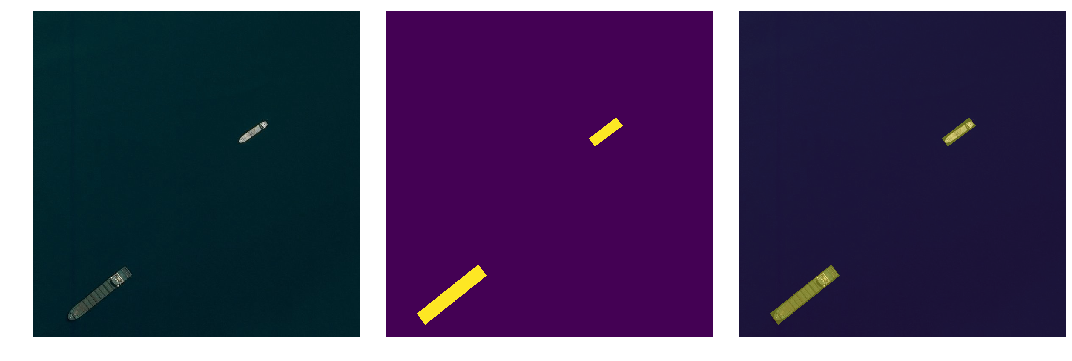

In [3]:
# Run length encoding CSV
rle_df = pd.read_csv(train_rle)

image_id = '0005d01c8.jpg'
image_shape = (768, 768)

image_path = os.path.join(trainset_dir, image_id)
img = Image.open(image_path)
img_masks = rle_df.loc[rle_df['ImageId'] == image_id, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros(image_shape)
for mask in img_masks:
    all_masks += rle_decode(mask, image_shape)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

### Performance

In [4]:
mask = img_masks[0]
%timeit rle_decode(mask, image_shape)

167 µs ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Test encode

### Functionality test

Take a ground-truth RLE, decode it and then encode it again. The encoded RLE must match the ground-truth RLE. 

In [5]:
gt_rle = img_masks[0]
decoded_mask = rle_decode(gt_rle, image_shape)
rle = rle_encode(decoded_mask)
if gt_rle == rle:
    print("Encode is working correctly!")
else:
    print("Encode is not working correctly!")
    print()
    print("Ground-truth:")
    print(gt_rle)
    print()
    print("Output from rle_encode:")
    print(rle)

Encode is working correctly!


### Performance

In [6]:
%timeit rle_encode(all_masks)

5.16 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
